# Show the Umap Gallery

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [37]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas as pd

import h5py
import seaborn as sns
import pandas as pd
from ulmo import io as ulmo_io
from ulmo.plotting import umap_gallery
from ulmo.ssl.analysis import latents_umap
from ulmo.plotting import load_palette
import umap

from matplotlib import pyplot as plt
from tqdm import trange

## Read latents filelatents_umap

In [4]:
latents_path = '/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/'
latents_file = 'last_latents.h5'
latents_path = os.path.join(latents_path, latents_file)

In [5]:
with h5py.File(latents_path, 'r') as f:
    latents_curl = f['valid'][:]

In [6]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_curl)

CPU times: user 3h 3min 54s, sys: 34min 49s, total: 3h 38min 44s
Wall time: 38min 12s


In [9]:
valid_embedding = latents_mapping.transform(latents_curl)

In [14]:
valid_tbl = {}
valid_tbl['U0'] = valid_embedding[:, 0]
valid_tbl['U1'] = valid_embedding[:, 1]
valid_tbl = pd.DataFrame(valid_tbl)

In [17]:
import pyarrow.feather as feather
write_to_file = '../llc_modis_2012_curl_latents/umap_latents_curl.feather'
feather.write_feather(valid_tbl, write_to_file)

## Plot the UMAP scatter plot

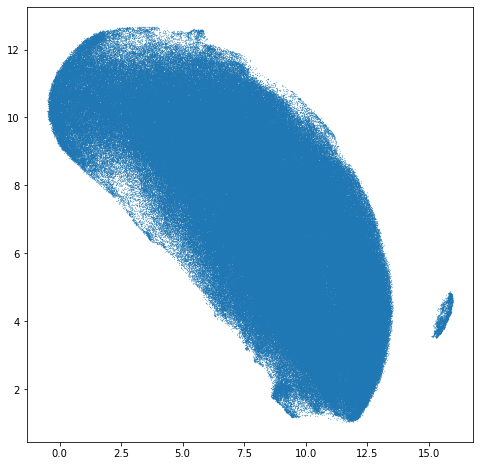

In [13]:
num_samples = valid_embedding.shape[0]
point_size = 20.0 / np.sqrt(num_samples)
dpi = 100
width, height = 800, 800

plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(valid_embedding[:, 0], 
            valid_embedding[:, 1], s=point_size)
plt.savefig('./llc_modis_2012_curl_valid_UMAP_epoch_20.png')

## Plot the Umap Gallery
### Small modification of Prof. X's function

In [45]:
def set_fontsize(ax, fsz):
    """
    Set the fontsize throughout an Axis
    Args:
        ax (Matplotlib Axis):
        fsz (float): Font size
    Returns:
    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)

In [43]:
def umap_gallery(main_tbl, data_array, outfile=None, point_sz_scl=1., width=800, 
                 height=800, vmnx=(-1000.,None), dxdy=(0.3, 0.3),
                 Nx=20, debug=None):
    """Generate a UMAP plot and overplot a gallery
    of cutouts
    Args:
        main_tbl (pandas.DataFrame): Table of quantities.
        data_array (np.array): Cutouts images.
        outfile (str, optional): Outfile for the figure. Defaults to None.
        point_sz_scl (float, optional): Point size for UMAP points. Defaults to 1..
        width (int, optional): Width of the figure. Defaults to 800.
        height (int, optional): Height of the figure. Defaults to 800.
        vmnx (tuple, optional): Color bar vmin,vmax. Defaults to (-1000.,None).
        dxdy (tuple, optional): Amount to pad the xlim, ylim by. Defaults to (0.3, 0.3).
        Nx (int, optional): Number of cutout images in x to show. Defaults to 20.
        debug (bool, optional): Debug? Defaults to None.
    Returns:
        matplotlib.plt.Axes: Axis
    """

    _, cm = load_palette()

    num_samples = len(main_tbl)
    point_size = point_sz_scl / np.sqrt(num_samples)
    dpi = 100

    # New plot
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    img = ax.scatter(main_tbl.U0, main_tbl.U1,
            s=point_size)
    #
    ax.set_xlabel(r'$U_0$')
    ax.set_ylabel(r'$U_1$')

    # Set boundaries
    xmin, xmax = main_tbl.U0.min()-dxdy[0], main_tbl.U0.max()+dxdy[0]
    ymin, ymax = main_tbl.U1.min()-dxdy[1], main_tbl.U1.max()+dxdy[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ###################
    # Gallery time

    # Grid
    xval = np.linspace(xmin, xmax, num=Nx)
    dxv = xval[1]-xval[0]
    yval = np.arange(ymin, ymax+dxv, step=dxv)

    # Ugly for loop
    pp_hf = None
    ndone = 0
    if debug:
        nmax = 100
    else:
        nmax = 1000000000
    for x in xval[:-1]:
        for y in yval[:-1]:
            pts = np.where((main_tbl.U0 >= x) & (main_tbl.U0 < x+dxv) & (
                main_tbl.U1 >= y) & (main_tbl.U1 < y+dxv))[0]
            if len(pts) == 0:
                continue

            # Pick a random one
            ichoice = np.random.choice(len(pts), size=1)
            idx = int(pts[ichoice])
            cutout = data_array[idx][0]

            # Image
            axins = ax.inset_axes(
                    [x, y, 0.9*dxv, 0.9*dxv], 
                    transform=ax.transData)
            _ = sns.heatmap(np.flipud(cutout), xticklabels=[], 
                     #vmin=vmnx[0], vmax=vmnx[1],
                     yticklabels=[], cmap=cm, cbar=False,
                     ax=axins)
            ndone += 1
            #print(f'ndone= {ndone}, LL={cutout.LL}')
            if ndone > nmax:
                break
        if ndone > nmax:
            break

    set_fontsize(ax, 15.)
    ax.set_aspect('equal', 'datalim')
    # Finish
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")

    return ax

## Read the llc_modis_2012_curl data set

In [24]:
curl_data_path = '../../../experiments/datasets/llc_kin_dataset/LLC_modis2012_curl_preproc.h5'

In [27]:
with h5py.File(curl_data_path, 'r') as f:
    llc_modis_curl = f['valid'][:]

Wrote: ./umap_gallery_epoch_20.png


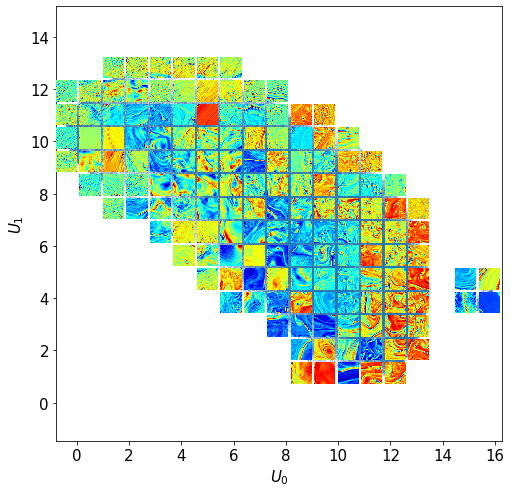

In [46]:
umap_gallery_file = './umap_gallery_epoch_20.png'
ax = umap_gallery(valid_tbl, llc_modis_curl, umap_gallery_file)